# Project for SYSC5001

### Simulation of a manufacturing plant

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from random import expovariate, weibullvariate, randint

## Creating the workstation variables and methods 
#### This stores the variables for each workstation,as well, the methods to start and finish the activities

In [59]:
class workstation:
    def __init__(self,param,iteration): #---------------------Variables 
        self.stat = 0         #Flag for worspace busy = 1, iddle = 0
        self.bufferC1 = 0     #
        self.bufferC2 = 0     #
        self.bufferC3 = 0     #
        self.work_time = 1    #Stores the total working time
        self.start_time = 0   #Store the starting time in order to compute the working time
        self.Production = 0   #Stores the total amount of Production
        self.SS_Production = 0 #Stores the total amount of Components Inspected at Steady-state
        self.parameters = param #Stores the parameters for random variable function
        self.efficiency = ['']*iteration
        self.Prod_rate = ['']*iteration
    def start_ws(self, W,clock, variable):
        #get_random time
        time = variable[W].loc[self.Production]
        #change status
        self.stat = 1
        self.start_time = clock
        self.bufferC1 -= 1          #Consume 1 component from the buffer C1
        if W == 'w2':
            self.bufferC2 -= 1      #Consume 1 component from the buffer C2
        elif W == 'w3':
            self.bufferC3 -= 1      #Consume 1 component from the buffer C3
        #schedule next event
        next_event = [time+clock, W,'Finish '+ W]
        return next_event
    def end_ws(self, clock):
        #change status
        self.stat = 0
        self.work_time = self.work_time + clock - self.start_time
        self.Production += 1
    def statistics(self, count,Clock,ClockSS):
        self.efficiency[count] = self.work_time/(Clock - ClockSS)
        self.Prod_rate[count] = (self.Production/self.work_time)*60
    def reset_statistics(self):
        self.Production = 0
        self.work_time = 1

## Creating the Inspectors variables and methods
#### This stores the variables for each inspector, as well has two methods to start and to finish the activities 

In [72]:
class inspector:
    def __init__(self, iteration): #---------------------Variables 
        self.stat = 0       #Flag for inspector busy = 1, iddle = 0
        self.block = 0      #Flag for inspector blocked due to lack of free spot to deliver
        self.work_time = 1  #Stores the total working time 
        self.start_time = 0 #Store the starting time in order to compute the working time
        self.C1 = 0 #Component waiting to deliver
        self.C2 = 0 #Component waiting to deliver
        self.C3 = 0 #Component waiting to deliver
        self.Production = 0   #Stores the total amount of Components Inspected
        self.efficiency = ['']*iteration
        self.aver = 0         #average processing time
        self.Prod_rate = ['']*iteration
    def start_ipc(self, C, insp, clock, variable):#----------Method used to start one activity
        #get_random time
        time = variable[C].loc[self.Production]
        #change status
        self.stat = 1     #Set status to busy 
        self.start_time = clock
        #schedule next event/ Return information to input on the queue
        next_event = [time+clock,'insp'+insp,'Finish '+C]
        return next_event
    def end_ipc(self, clock):#--------------------------Method used to stop the current activity
        self.stat = 0     #Set status to iddle
        self.Production += 1
        self.work_time = self.work_time + clock - self.start_time 
    def statistics(self, count, clock, clockSS):
        self.efficiency[count] = self.work_time/(clock - clockSS)
        self.Prod_rate[count] = (self.Production/self.work_time)*60
    def reset_statistics(self):
        self.Production = 0
        self.work_time = 1

## Insert new event to the Event List

In [4]:
def event_list(lista):
    lista = [lista[0],['w1={}'.format(w1.stat),
                  'w1_buffer_C1={}'.format(w1.bufferC1),
                  'w2={}'.format(w2.stat,w2.bufferC1),
                  'w2_bufferC1={}'.format(w2.bufferC1),
                  'w2_bufferC2={}'.format(w2.bufferC2),
                  'w3={}'.format(w3.stat),
                  'w3_bufferC1={}'.format(w3.bufferC1),
                  'w3_bufferC3={}'.format(w3.bufferC3),
                  'Insp1={}'.format(insp1.stat),
                  'Insp1_Blocked={}'.format(insp1.block),
                  'Insp2={}'.format(insp2.stat),
                  'Insp2_Blocked={}'.format(insp2.block),
                 ],queue,lista[1],lista[2],['w1_Prod={}'.format(w1.Production),
                                           'w2_Prod={}'.format(w2.Production),
                                           'w3_Prod={}'.format(w3.Production)]]
    
    Events.loc[-1] = lista  # adding a row
    Events.index = Events.index + 1  # shifting index
    Events.reset_index(inplace=True)
    Events.drop('index',axis=1, inplace=True)

## Insert new event to the Future Event queue

In [5]:
def insert(lista):
    queue.loc[-1] = lista  # adding a row
    queue.index = queue.index + 1  # shifting index
    queue.sort_values(by='Clock',axis=0, inplace=True)
    queue.reset_index(inplace=True)
    queue.drop('index',axis=1, inplace=True)

## Getting and dropping first from list

In [6]:
def next_event():
    nexteve = queue.loc[0]
    queue.drop(0,axis=0,inplace=True)
    queue.reset_index(inplace=True)
    queue.drop('index',axis=1, inplace=True)
    return list(nexteve)

## Random Variables Generator

In [41]:
def var_gen(amount):
    columns = ['C1','C2','C3','w1','w2','w3']
    var = pd.DataFrame(columns = columns)
    for i in range(amount):
        var.loc[-1] = [weibullvariate(10.8,1),
                       weibullvariate(14.8,1),
                       expovariate(0.0758),
                       expovariate(0.195),
                       weibullvariate(6,1),
                       weibullvariate(4.2,1)]
        var.index = var.index + 1  # shifting index
    return var

## Initialization

In [181]:
def initialization(itera):
    global Clock,ClockSS,iteration,count,event,queue,Events,w1,w2,w3,insp1,insp2,insp3,ov_eff
    iteration = itera
    Clock = 1
    ClockSS = 0
    count = 0
    event = ['','','']   # 0-Clock, 1-Entity, 2-Event
    queue = pd.DataFrame(columns=['Clock', 'Entity', 'Event'])
    Events = pd.DataFrame(columns=['Clock', 'System State','FEQ','Entity', 'Event','Production'])
    w1 = workstation([1,0.195,1],iteration)
    w2 = workstation([1,6.0,1],iteration)
    w3 = workstation([1,4.2,1],iteration)
    insp1 = inspector(iteration)
    insp2 = inspector(iteration)
    insp3 = inspector(iteration)
    ov_eff = ['']*iteration

In [136]:
event[0]

2.8492445026635167

## Simulation Loop

In [316]:
def loop():
    global Clock,ClockSS,iteration,count,event,queue,Events,w1,w2,w3,insp1,insp2,ov_eff,variable
    
    while True: 
        #Getting a new event from the list
        if queue.size:             #Check if is not empty
            event = next_event()
            Clock = event[0]           #Updating Clock
        #Executing Change of states triggered by the event
        if event[2] == 'Finish C1':
            insp1.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w1.bufferC1 <= w2.bufferC1 and w1.bufferC1 <= w3.bufferC1 and w1.bufferC1 < 2:
                w1.bufferC1 += 1
            elif w2.bufferC1 <= w3.bufferC1 and w2.bufferC1 < 2:
                w2.bufferC1 += 1
            elif w3.bufferC1 < 2:
                w3.bufferC1 += 1
            else:
                insp1.block = 1
                insp1.C1 = 1
        if event[2] == 'Finish C2':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w2.bufferC2 < 2:
                w2.bufferC2 += 1
            else:
                insp2.block = 1
                insp2.C2 = 1
        if event[2] == 'Finish C3':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w3.bufferC3 < 2:
                w3.bufferC3 += 1
            else:
                insp2.block = 1
                insp2.C3 = 1
        if event[2] == 'Finish w1':
            w1.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w2':
            w2.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w3':
            w3.end_ws(Clock)
            event_list([Clock, event[1], event[2]])

        #Check for system status and initialyse activities if possible
        #Workstation 1 -----------------------------------------Check if worksation can start new activity
        busy1 = w1.stat
        C1 = w1.bufferC1
        if not busy1 and (C1>0):
            insert(w1.start_ws('w1', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w1','Starting w1'])
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w1.bufferC1 += 1
        #Workstation 2 -----------------------------------------Check if worksation can start new activity
        busy2 = w2.stat
        C1 = w2.bufferC1
        C2 = w2.bufferC2
        if not busy2 and (C1>0) and (C2>0):
            insert(w2.start_ws('w2', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w2','Starting w2'])
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w3.bufferC1 += 1
            if insp2.C2 == 1:
                insp2.C2 = 0
                insp2.block = 0
                w2.bufferC2 += 1
        #Workstation 3 -----------------------------------------Check if worksation can start new activity
        busy3 = w3.stat
        C1 = w3.bufferC1
        C3 = w3.bufferC3
        if not busy3 and (C1>0) and (C3>0):
            insert(w3.start_ws('w3', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w3','Starting w3'])
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w3.bufferC1 += 1
            if insp2.C3 == 1:
                insp2.C3 = 0
                insp2.block = 0
                w3.bufferC3 += 1
                
        #inspector 1                                          #Check if inspector can start new activity
        busy1 = insp1.stat
        blocked1 = insp1.block
        if not busy1 and not blocked1: 
            insert(insp1.start_ipc('C1', '1', Clock, variable))              #Schedule finishing event
            event_list([Clock,'insp1','Starting C1'])
        #inspector 2                                          #Check if inspector can start new activity
        busy2 = insp2.stat
        blocked2 = insp2.block
        if not busy2 and not blocked1:
            rand = randint(0,1)
            if rand == 1:
                insert(insp2.start_ipc('C2', '2', Clock, variable))          #Schedule finishing event
                event_list([Clock,'insp2','Starting C2'])
            else:
                insert(insp2.start_ipc('C3', '2', Clock, variable))          #Schedule finishing event
                event_list([Clock,'insp2','Starting C3'])
        
        #Collecting statistics from de entities
        insp1.statistics(count,Clock,ClockSS)
        insp2.statistics(count,Clock,ClockSS)
        insp3.statistics(count,Clock,ClockSS)
        w1.statistics(count,Clock,ClockSS)
        w2.statistics(count,Clock,ClockSS)
        w3.statistics(count,Clock,ClockSS)
        
        #Reseting the production counters on the beginning of steady-state part
        if count == 800:
            ClockSS = Clock #Clock at Steady-State
            insp1.reset_statistics()
            insp2.reset_statistics()
            insp3.reset_statistics()
            w1.reset_statistics()
            w2.reset_statistics()
            w3.reset_statistics()
            
        #Finishing the Simulation
        count += 1
        if count >= iteration:
            break
#-------------------------------------------------Statistics------------------------------------    
    #Computing the Cumulative Efficiency and Production Rate
    W_aver = (np.array(w1.efficiency)+np.array(w1.efficiency)+np.array(w3.efficiency))/3
    I_aver = (np.array(insp1.efficiency)+np.array(insp1.efficiency))/2
    data1 = {'Inspector 1':insp1.efficiency,
            'Inspector 2':insp2.efficiency,
            'Inspector 3':insp2.efficiency,
            'Workstation 1':w1.efficiency,
            'Workstation 2':w2.efficiency,
            'Workstation 3':w3.efficiency,
            'Inspectors Average':I_aver,
            'Workstation Average':W_aver}
    ov_ef = pd.DataFrame(data1)
    data2 = {'Inspector 1':insp1.Prod_rate,
             'Inspector 2':insp2.Prod_rate,
             'Inspector 3':insp2.Prod_rate,
             'Workstation 1':w1.Prod_rate,
             'Workstation 2':w2.Prod_rate,
             'Workstation 3':w3.Prod_rate}
    prod_rate = pd.DataFrame(data2)
    
    #Computing the moving average production rate
    mov_ave = pd.DataFrame(columns=['Inspector 1',
                                    'Inspector 2',
                                    'Inspector 3',
                                    'Workstation 1',
                                    'Workstation 2',
                                    'Workstation 3'])
    for i in range(50,iteration,1):
        is1 = (sum(insp1.Prod_rate[i-50:i])/51)
        is2 = (sum(insp2.Prod_rate[i-50:i])/51)
        is3 = (sum(insp3.Prod_rate[i-50:i])/51)
        ws1 = (sum(w1.Prod_rate[i-50:i])/51)
        ws2 = (sum(w2.Prod_rate[i-50:i])/51)
        ws3 = (sum(w3.Prod_rate[i-50:i])/51)
        mov_ave.loc[i] = [is1,is2,is3,ws1,ws2,ws3]
        
    #Computing the throughput 
    throughput = [insp1.Production/(Clock-ClockSS),
                  insp2.Production/(Clock-ClockSS),
                  insp3.Production/(Clock-ClockSS),
                  w1.Production/(Clock-ClockSS),
                  w2.Production/(Clock-ClockSS),
                  w3.Production/(Clock-ClockSS),0]
    throughput[6] = sum(throughput[3:5])    
    return ov_ef, prod_rate, mov_ave, throughput

## Alternative Design 1

Inspector 2 works with C1 with priority to deliver to Workstation 3 and then to Workstation 2. However, Inspector 2 will not produce C2 anymore. And then, Inspector 1 will produce C2 instead.

First Alternative: Inspector 1 producing C2 and Inspector 2 producing C1 but not C2.
The changes are only on the loop. 

•	Events added on the part Executing Events: ‘Insp1 Finishing C2’ and changing ‘Insp2 finishing C2’ for ‘Insp2 finishing C1’. Inside the event ‘Insp2 finishing C1’ the delivery order should be first to w3.bufferC1, second to w2.bufferC1 and finally w1.bufferC1. 

•	To start a new task on Inspector 1, it should generate a random binary number to decide with component to inspect, C1 or C2.

•	To start a new task on Inspector 2, it should change C2 by C1.


In [317]:
def loop_AD_1():
    global Clock,ClockSS,iteration,count,event,queue,Events,w1,w2,w3,insp1,insp2,ov_eff,variable
    
    while True: 
        #Getting a new event from the list
        if queue.size:             #Check if is not empty
            event = next_event()
            Clock = event[0]           #Updating Clock
        #Executing Change of states triggered by the event
        if event[2] == 'Finish C1' and event[1] == 'insp1':
            insp1.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w1.bufferC1 <= w2.bufferC1 and w1.bufferC1 <= w3.bufferC1 and w1.bufferC1 < 2:
                w1.bufferC1 += 1
            elif w2.bufferC1 <= w3.bufferC1 and w2.bufferC1 < 2:
                w2.bufferC1 += 1
            elif w3.bufferC1 < 2:
                w3.bufferC1 += 1
            else:
                insp1.block = 1
                insp1.C1 = 1
        if event[2] == 'Finish C2':
            insp1.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w2.bufferC2 < 2:
                w2.bufferC2 += 1
            else:
                insp1.block = 1
                insp1.C2 = 1
        if event[2] == 'Finish C1' and event[1] == 'insp2':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w3.bufferC1 <= w2.bufferC1 and w3.bufferC1 <= w1.bufferC1 and w3.bufferC1 < 2:
                w3.bufferC1 += 1
            elif w2.bufferC1 <= w1.bufferC1 and w2.bufferC1 < 2:
                w2.bufferC1 += 1
            elif w1.bufferC1 < 2:
                w1.bufferC1 += 1
            else:
                insp2.block = 1
                insp2.C1 = 1        
        if event[2] == 'Finish C3':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w3.bufferC3 < 2:
                w3.bufferC3 += 1
            else:
                insp2.block = 1
                insp2.C3 = 1
        if event[2] == 'Finish w1':
            w1.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w2':
            w2.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w3':
            w3.end_ws(Clock)
            event_list([Clock, event[1], event[2]])

        #Check for system status and initialyse activities if possible
        #Workstation 1 -----------------------------------------Check if workstation can start new activity
        busy1 = w1.stat
        C1 = w1.bufferC1
        if not busy1 and (C1>0):
            insert(w1.start_ws('w1', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w1','Starting w1'])
            #Unblock Inspectors
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w1.bufferC1 += 1
            elif insp2.C1 == 1:
                insp2.C1 = 0
                insp2.block = 0
                w1.bufferC1 += 1
        #Workstation 2 -----------------------------------------Check if workstation can start new activity
        busy2 = w2.stat
        C1 = w2.bufferC1
        C2 = w2.bufferC2
        if not busy2 and (C1>0) and (C2>0):
            insert(w2.start_ws('w2', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w2','Starting w2'])
            #Unblock Inspectors
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w2.bufferC1 += 1
            elif insp2.C1 == 1:
                insp2.C1 = 0
                insp2.block = 0
                w2.bufferC1 += 1
            if insp1.C2 == 1:
                insp1.C2 = 0
                insp1.block = 0
                w2.bufferC2 += 1
        #Workstation 3 -----------------------------------------Check if workstation can start new activity
        busy3 = w3.stat
        C1 = w3.bufferC1
        C3 = w3.bufferC3
        if not busy3 and (C1>0) and (C3>0):
            insert(w3.start_ws('w3', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w3','Starting w3'])
            #Unblock Inspectors
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w3.bufferC1 += 1
            elif insp2.C1 == 1:
                insp2.C1 = 0
                insp2.block = 0
                w3.bufferC1 += 1
            if insp2.C3 == 1:
                insp2.C3 = 0
                insp2.block = 0
                w3.bufferC3 += 1

        #inspector 1                                          #Check if inspector can start new activity
        busy1 = insp1.stat
        blocked1 = insp1.block
        if not busy1 and not blocked1: 
            rand = randint(0,1)
            if rand == 1 or w2.bufferC2 == 2:
                insert(insp1.start_ipc('C1', '1', Clock, variable))              #Schedule finishing event
                event_list([Clock,'insp1','Starting C1'])
            else:
                insert(insp1.start_ipc('C2', '1', Clock, variable))          #Schedule finishing event
                event_list([Clock,'insp1','Starting C2'])
        #inspector 2                                          #Check if inspector can start new activity
        if not insp2.stat and not insp2.block:
            rand = randint(0,1)
            if rand == 1 or w3.bufferC3 == 2:
                insert(insp2.start_ipc('C1', '2', Clock, variable))          #Schedule finishing event
                event_list([Clock,'insp2','Starting C1'])
            else:
                insert(insp2.start_ipc('C3', '2', Clock, variable))          #Schedule finishing event
                event_list([Clock,'insp2','Starting C3'])

        #Collecting statistics from de entities
        insp1.statistics(count,Clock,ClockSS)
        insp2.statistics(count,Clock,ClockSS)
        insp3.statistics(count,Clock,ClockSS)
        w1.statistics(count,Clock,ClockSS)
        w2.statistics(count,Clock,ClockSS)
        w3.statistics(count,Clock,ClockSS)
        
        #Reseting the production counters on the beginning of steady-state part
        if count == 800:
            ClockSS = Clock #Clock at Steady-State
            insp1.reset_statistics()
            insp2.reset_statistics()
            insp3.reset_statistics()
            w1.reset_statistics()
            w2.reset_statistics()
            w3.reset_statistics()
            
        #Finishing the Simulation
        count += 1
        if count >= iteration:
            break
#-------------------------------------------------Statistics------------------------------------    
    #Computing the Cumulative Efficiency and Production Rate
    W_aver = (np.array(w1.efficiency)+np.array(w1.efficiency)+np.array(w3.efficiency))/3
    I_aver = (np.array(insp1.efficiency)+np.array(insp1.efficiency))/2
    data1 = {'Inspector 1':insp1.efficiency,
            'Inspector 2':insp2.efficiency,
            'Inspector 3':insp2.efficiency,
            'Workstation 1':w1.efficiency,
            'Workstation 2':w2.efficiency,
            'Workstation 3':w3.efficiency,
            'Inspectors Average':I_aver,
            'Workstation Average':W_aver}
    ov_ef = pd.DataFrame(data1)
    data2 = {'Inspector 1':insp1.Prod_rate,
             'Inspector 2':insp2.Prod_rate,
             'Inspector 3':insp2.Prod_rate,
             'Workstation 1':w1.Prod_rate,
             'Workstation 2':w2.Prod_rate,
             'Workstation 3':w3.Prod_rate}
    prod_rate = pd.DataFrame(data2)
    
    #Computing the moving average production rate
    mov_ave = pd.DataFrame(columns=['Inspector 1',
                                    'Inspector 2',
                                    'Inspector 3',
                                    'Workstation 1',
                                    'Workstation 2',
                                    'Workstation 3'])
    for i in range(50,iteration,1):
        is1 = (sum(insp1.Prod_rate[i-50:i])/51)
        is2 = (sum(insp2.Prod_rate[i-50:i])/51)
        is3 = (sum(insp3.Prod_rate[i-50:i])/51)
        ws1 = (sum(w1.Prod_rate[i-50:i])/51)
        ws2 = (sum(w2.Prod_rate[i-50:i])/51)
        ws3 = (sum(w3.Prod_rate[i-50:i])/51)
        mov_ave.loc[i] = [is1,is2,is3,ws1,ws2,ws3]
        
    #Computing the throughput 
    throughput = [insp1.Production/(Clock-ClockSS),
                  insp2.Production/(Clock-ClockSS),
                  insp3.Production/(Clock-ClockSS),
                  w1.Production/(Clock-ClockSS),
                  w2.Production/(Clock-ClockSS),
                  w3.Production/(Clock-ClockSS),0]
    throughput[6] = sum(throughput[3:5])    
    return ov_ef, prod_rate, mov_ave, throughput

## Alternative Design 2

The second alternative is to hire a new inspector, the Inspector 3 will work producing C1 with delivery priority to W3 and W2, without changes on the others inspectors.

The changes are on the initialization and loop part.

•	Build an object insp3 of type inspector on the initialization.

•	Add event ‘insp3 finishing C1’ in the same way of insp1 but delivering first to w3, second to w2 and then to w1.

•	Add a check in buffer status to unblock insp3 whenever there is free spot on any buffer C1.

In [318]:
def loop_AD_2():
    global Clock,ClockSS,iteration,count,event,queue,Events,w1,w2,w3,insp1,insp2,insp3,ov_eff,variable
    
    while True: 
        #Getting a new event from the list
        if queue.size:             #Check if is not empty
            event = next_event()
            Clock = event[0]           #Updating Clock
        #Executing Change of states triggered by the event
        if event[2] == 'Finish C1' and event[1] == 'insp1':
            insp1.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w1.bufferC1 <= w2.bufferC1 and w1.bufferC1 <= w3.bufferC1 and w1.bufferC1 < 2:
                w1.bufferC1 += 1
            elif w2.bufferC1 <= w3.bufferC1 and w2.bufferC1 < 2:
                w2.bufferC1 += 1
            elif w3.bufferC1 < 2:
                w3.bufferC1 += 1
            else:
                insp1.block = 1
                insp1.C1 = 1
        if event[2] == 'Finish C2':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w2.bufferC2 < 2:
                w2.bufferC2 += 1
            else:
                insp2.block = 1
                insp2.C2 = 1       
        if event[2] == 'Finish C3':
            insp2.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w3.bufferC3 < 2:
                w3.bufferC3 += 1
            else:
                insp2.block = 1
                insp2.C3 = 1
        if event[2] == 'Finish C1' and event[1] == 'insp3':
            insp3.end_ipc(Clock)
            event_list([Clock, event[1], event[2]])
            if w3.bufferC1 <= w2.bufferC1 and w3.bufferC1 <= w1.bufferC1 and w3.bufferC1 < 2:
                w3.bufferC1 += 1
            elif w2.bufferC1 <= w1.bufferC1 and w2.bufferC1 < 2:
                w2.bufferC1 += 1
            elif w1.bufferC1 < 2:
                w1.bufferC1 += 1
            else:
                insp3.block = 1
                insp3.C1 = 1 
        if event[2] == 'Finish w1':
            w1.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w2':
            w2.end_ws(Clock)
            event_list([Clock, event[1], event[2]])
        if event[2] == 'Finish w3':
            w3.end_ws(Clock)
            event_list([Clock, event[1], event[2]])

        #Check for system status and initialyse activities if possible
        #Workstation 1 -----------------------------------------Check if workstation can start new activity
        busy1 = w1.stat
        C1 = w1.bufferC1
        if not busy1 and (C1>0):
            insert(w1.start_ws('w1', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w1','Starting w1'])
            #Unblock Inspectors
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w1.bufferC1 += 1
            elif insp3.C1 == 1:
                insp3.C1 = 0
                insp3.block = 0
                w1.bufferC1 += 1
        #Workstation 2 -----------------------------------------Check if workstation can start new activity
        busy2 = w2.stat
        C1 = w2.bufferC1
        C2 = w2.bufferC2
        if not busy2 and (C1>0) and (C2>0):
            insert(w2.start_ws('w2', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w2','Starting w2'])
            #Unblock Inspectors
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w2.bufferC1 += 1
            elif insp3.C1 == 1:
                insp3.C1 = 0
                insp3.block = 0
                w2.bufferC1 += 1
            if insp2.C2 == 1:
                insp2.C2 = 0
                insp2.block = 0
                w2.bufferC2 += 1
        #Workstation 3 -----------------------------------------Check if workstation can start new activity
        busy3 = w3.stat
        C1 = w3.bufferC1
        C3 = w3.bufferC3
        if not busy3 and (C1>0) and (C3>0):
            insert(w3.start_ws('w3', Clock, variable))              #Schedule finishing event
            event_list([Clock,'w3','Starting w3'])
            #Unblock Inspectors
            if insp1.C1 == 1:
                insp1.C1 = 0
                insp1.block = 0
                w3.bufferC1 += 1
            elif insp3.C1 == 1:
                insp3.C1 = 0
                insp3.block = 0
                w3.bufferC1 += 1
            if insp2.C3 == 1:
                insp2.C3 = 0
                insp2.block = 0
                w3.bufferC3 += 1

        #inspector 1                                          #Check if inspector can start new activity
        busy1 = insp1.stat
        blocked1 = insp1.block
        if not busy1 and not blocked1:
            insert(insp1.start_ipc('C1', '1', Clock, variable))               #Schedule finishing event
            event_list([Clock,'insp1','Starting C1'])

        #inspector 2                                          #Check if inspector can start new activity
        if not insp2.stat and not insp2.block:
            rand = randint(0,1)
            if rand == 1 or w3.bufferC3 == 2:
                insert(insp2.start_ipc('C2', '2', Clock, variable))           #Schedule finishing event
                event_list([Clock,'insp2','Starting C2'])
            else:
                insert(insp2.start_ipc('C3', '2', Clock, variable))         #Schedule finishing event
                event_list([Clock,'insp2','Starting C3'])
                
        #inspector 3                                          #Check if inspector can start new activity
        busy3 = insp3.stat
        blocked3 = insp3.block
        if not busy3 and not blocked3:
            insert(insp3.start_ipc('C1', '3', Clock, variable))              #Schedule finishing event
            event_list([Clock,'insp3','Starting C1'])

        #Collecting statistics from de entities
        insp1.statistics(count,Clock,ClockSS)
        insp2.statistics(count,Clock,ClockSS)
        insp3.statistics(count,Clock,ClockSS)
        w1.statistics(count,Clock,ClockSS)
        w2.statistics(count,Clock,ClockSS)
        w3.statistics(count,Clock,ClockSS)
        
        #Reseting the production counters on the beginning of steady-state part
        if count == 800:
            ClockSS = Clock #Clock at Steady-State
            insp1.reset_statistics()
            insp2.reset_statistics()
            insp3.reset_statistics()
            w1.reset_statistics()
            w2.reset_statistics()
            w3.reset_statistics()
            
        #Finishing the Simulation
        count += 1
        if count >= iteration:
            break
#-------------------------------------------------Statistics------------------------------------    
    #Computing the Cumulative Efficiency and Production Rate
    W_aver = (np.array(w1.efficiency)+np.array(w1.efficiency)+np.array(w3.efficiency))/3
    I_aver = (np.array(insp1.efficiency)+np.array(insp1.efficiency))/2
    data1 = {'Inspector 1':insp1.efficiency,
            'Inspector 2':insp2.efficiency,
            'Inspector 3':insp2.efficiency,
            'Workstation 1':w1.efficiency,
            'Workstation 2':w2.efficiency,
            'Workstation 3':w3.efficiency,
            'Inspectors Average':I_aver,
            'Workstation Average':W_aver}
    ov_ef = pd.DataFrame(data1)
    data2 = {'Inspector 1':insp1.Prod_rate,
             'Inspector 2':insp2.Prod_rate,
             'Inspector 3':insp2.Prod_rate,
             'Workstation 1':w1.Prod_rate,
             'Workstation 2':w2.Prod_rate,
             'Workstation 3':w3.Prod_rate}
    prod_rate = pd.DataFrame(data2)
    
    #Computing the moving average production rate
    mov_ave = pd.DataFrame(columns=['Inspector 1',
                                    'Inspector 2',
                                    'Inspector 3',
                                    'Workstation 1',
                                    'Workstation 2',
                                    'Workstation 3'])
    for i in range(50,iteration,1):
        is1 = (sum(insp1.Prod_rate[i-50:i])/51)
        is2 = (sum(insp2.Prod_rate[i-50:i])/51)
        is3 = (sum(insp3.Prod_rate[i-50:i])/51)
        ws1 = (sum(w1.Prod_rate[i-50:i])/51)
        ws2 = (sum(w2.Prod_rate[i-50:i])/51)
        ws3 = (sum(w3.Prod_rate[i-50:i])/51)
        mov_ave.loc[i] = [is1,is2,is3,ws1,ws2,ws3]
        
    #Computing the throughput 
    throughput = [insp1.Production/(Clock-ClockSS),
                  insp2.Production/(Clock-ClockSS),
                  insp3.Production/(Clock-ClockSS),
                  w1.Production/(Clock-ClockSS),
                  w2.Production/(Clock-ClockSS),
                  w3.Production/(Clock-ClockSS),0]
    throughput[6] = sum(throughput[3:5])    
    return ov_ef, prod_rate, mov_ave, throughput

## Control Loop

This control loop is created to call the realizations of the model in 'i' times. And then, to store the datasets of the results. 

In [192]:
col1 = ['Inspector 1',
        'Inspector 2',
        'Inspector 3',
        'Workstation 1',
        'Workstation 2',
        'Workstation 3',
        'Inspectors Average',
        'Workstation Average']
col2 = ['Inspector 1',
        'Inspector 2',
        'Inspector 3',
        'Workstation 1',
        'Workstation 2',
        'Workstation 3']
col3 = ['Inspector 1',
        'Inspector 2',
        'Inspector 3',
        'Workstation 1',
        'Workstation 2',
        'Workstation 3',
        'Total']
ans = pd.DataFrame(columns=col1)
ans1 = pd.DataFrame(columns=col1)
ans2 = pd.DataFrame(columns=col1)
Comp_rate = pd.DataFrame(columns=col2)
Comp_rate1 = pd.DataFrame(columns=col2)
Comp_rate2 = pd.DataFrame(columns=col2)
Throughput = pd.DataFrame(columns=col3)
Throughput1 = pd.DataFrame(columns=col3)
Throughput2 = pd.DataFrame(columns=col3)

ite = 1800

for i in range(25):
    variable = var_gen(1000)
    initialization(ite)
    ov_ef, prod_rate, move, throughput = loop()
    initialization(ite)
    ov_ef1, prod_rate1, move1, throughput1 = loop_AD_1()
    initialization(ite)
    ov_ef2, prod_rate2, move2, throughput2 = loop_AD_2()
    ans.loc[i] = ov_ef.iloc[ite-1]  # Overall Effectiveness
    ans1.loc[i] = ov_ef1.iloc[ite-1]  # Overall Effectiveness
    ans2.loc[i] = ov_ef2.iloc[ite-1]  # Overall Effectiveness        

    Comp_rate.loc[i] = prod_rate.iloc[ite-1] #Production rate, considering only the busy time.
    
    Throughput.loc[i] = throughput  #Production rate, considering the total time
    Throughput.loc[i] = Throughput.loc[i]*60 #Throughput per hour
    Throughput1.loc[i] = throughput1  #Production rate, considering the total time
    Throughput1.loc[i] = Throughput1.loc[i]*60 #Throughput per hour
    Throughput2.loc[i] = throughput2  #Production rate, considering the total time
    Throughput2.loc[i] = Throughput2.loc[i]*60 #Throughput per hour
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [216]:
ov_ef1.drop('Inspector 3', axis=1, inplace = True)
ov_ef1.drop('Inspector 3', axis=1, inplace = True)

# Results

Overall Effectiveness

In [245]:
result = pd.DataFrame()
result['Scenario 0'] = np.mean(ans, axis=0)
result['Scenario 1'] = np.mean(ans1, axis=0)
result['Scenario 2'] = np.mean(ans2, axis=0)

In [228]:
import csv

In [251]:
result.to_csv('Results.csv', encoding='utf-8')

Throughput and its standard deviation and mean value. 
To computing the Confidence Interval

### Computing Standard deviation and Mean Value

In [253]:
S = np.std(Throughput, axis=0)
S1 = np.std(Throughput1, axis=0)
S2 = np.std(Throughput2, axis=0)

In [254]:
miu = np.mean(Throughput, axis=0)
miu1 = np.mean(Throughput1, axis=0)
miu2 = np.mean(Throughput2, axis=0)

In [266]:
S.drop(['Inspector 1','Inspector 2','Inspector 3'], axis=0, inplace=True)
S1.drop(['Inspector 1','Inspector 2','Inspector 3'], axis=0, inplace=True)
S2.drop(['Inspector 1','Inspector 2','Inspector 3'], axis=0, inplace=True)

In [269]:
miu.drop(['Inspector 1','Inspector 2','Inspector 3'], axis=0, inplace=True)
miu1.drop(['Inspector 1','Inspector 2','Inspector 3'], axis=0, inplace=True)
miu2.drop(['Inspector 1','Inspector 2','Inspector 3'], axis=0, inplace=True)

### Confidence Interval

Upper Bound

In [310]:
ub = (1.705*S)/5 + miu
ub1 = (1.705*S1)/5 + miu1
ub2 = (1.705*S2)/5 + miu2

Lower Bound

In [311]:
lb = (-1.705*S)/5 + miu
lb1 = (-1.705*S1)/5 + miu1
lb2 = (-1.705*S2)/5 + miu2

### Formating the results

In [292]:
column_results = ['Lower Bound','Mean','Upper Bound','St Deviation']
index_result = ['Scenario 0','Scenario 1','Scenario 2']

In [313]:
Work = pd.DataFrame(columns = column_results, index=index_result)
for k in range(4):
    Work.loc[index_result[0]] = [lb[k],miu[k],ub[k],S[k]]
    Work.loc[index_result[1]] = [lb1[k],miu1[k],ub1[k],S1[k]]
    Work.loc[index_result[2]] = [lb2[k],miu2[k],ub2[k],S2[k]]
    file = 'Workstation'+str(k)+'.csv'
    Work.to_csv(file, encoding='utf-8')

## This results is to evaluate the Little`s Law

#### Time per Production

In [201]:
print('inspector 1:',insp1.work_time/insp1.Production)
print('inspector 2:',insp2.work_time/insp2.Production)
print('workstation 1:',w1.work_time/w1.Production)
print('workstation 2:',w2.work_time/w2.Production)
print('workstation 3:',w3.work_time/w3.Production)

inspector 1: 11.76831529459711
inspector 2: 13.56476646918656
workstation 1: 5.197499795238548
workstation 2: 6.270778153562117
workstation 3: 3.917281259346626


#### Production per hour

In [202]:
print('inspector 1:',(insp1.Production/insp1.work_time)*60)
print('inspector :',(insp2.Production/insp2.work_time)*60)
print('workstation 1:',(w1.Production/w1.work_time)*60)
print('workstation 2:',(w2.Production/w2.work_time)*60)
print('workstation 3:',(w3.Production/w3.work_time)*60)

inspector 1: 5.098435799688873
inspector : 4.42322395570132
workstation 1: 11.54401199880109
workstation 2: 9.568190506933655
workstation 3: 15.31674547413212


### Plotting the results

In [203]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

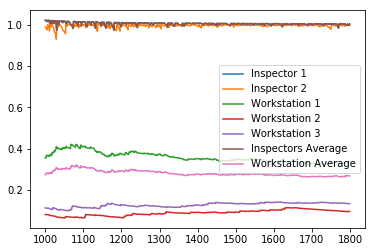

In [219]:
ov_ef1.loc[1000:1800].plot()

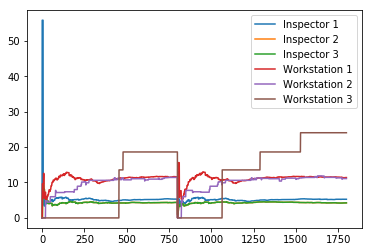

In [205]:
prod_rate.plot()

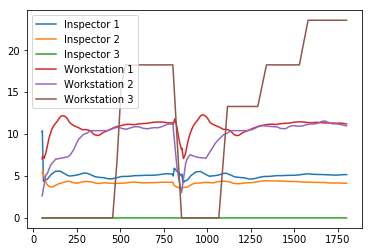

In [206]:
move.plot()